Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FBHHYR_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FBHHYR_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.FBHHYR_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Fitting 5 folds for each of 3 candidates, totalling 15 fits

Best Parameters: {'C': 1, 'kernel': 'linear'}

Test Accuracy: 0.8530

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85       495
           1       0.84      0.87      0.86       505

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



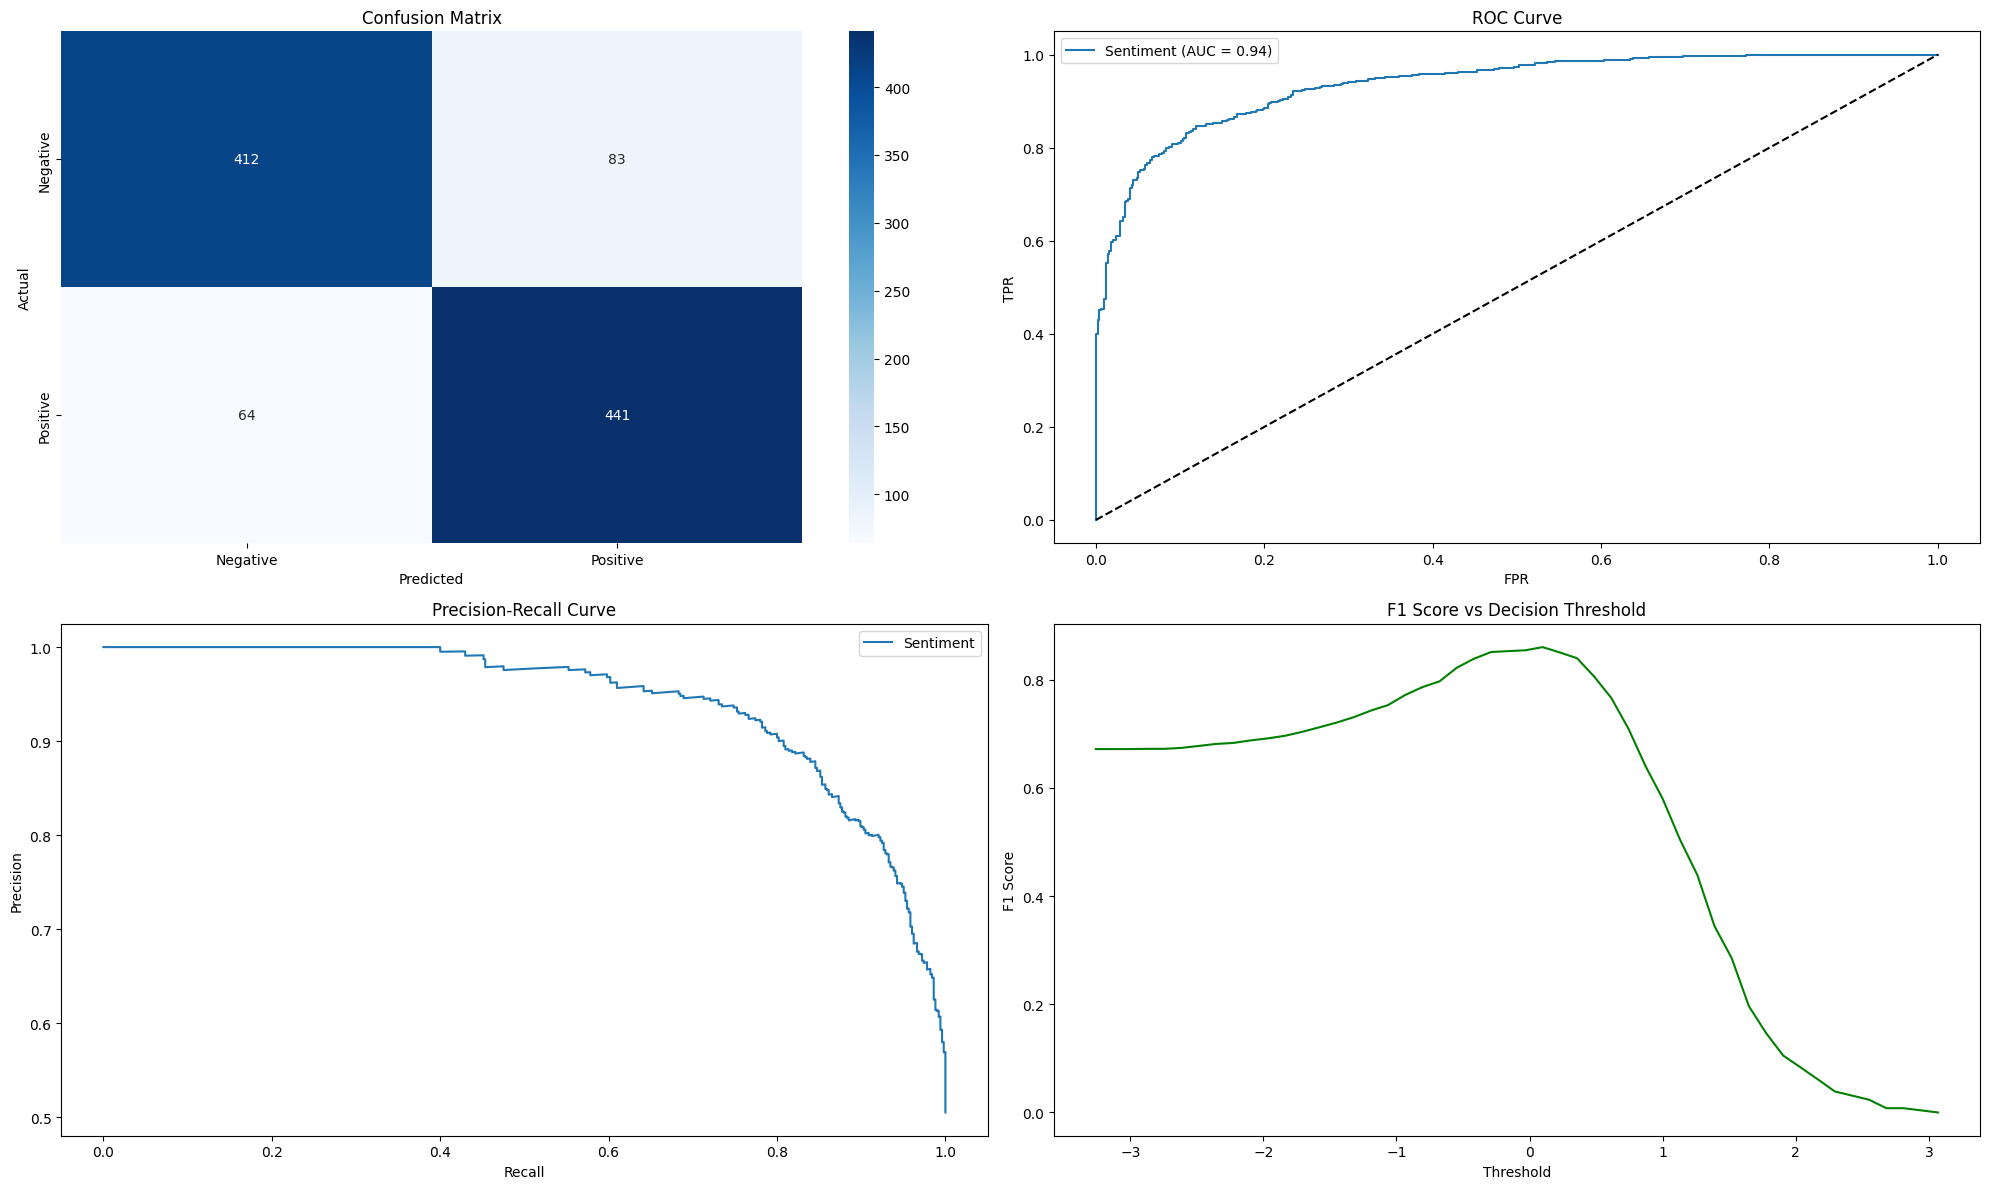

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds  # Stable data source
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve, f1_score)

# 1. Load Dataset using TensorFlow Datasets (Stable & Reliable)
# This will download the dataset directly to your Colab session
ds, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_ds = ds['train'].take(5000) # Taking a 5k sample for speed

# Convert to Pandas DataFrame
reviews, labels = [], []
for text, label in tfds.as_numpy(train_ds):
    reviews.append(text.decode('utf-8'))
    labels.append(label)

df = pd.DataFrame({'review': reviews, 'sentiment': labels})

# 2. Features and Target Setup
X = df['review']
y = df['sentiment']
n_classes = len(np.unique(y))

# 3. Data Preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# TfidfVectorizer converts text into numerical features
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# 4. Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear']
}

svm = SVC(probability=True, random_state=42)
grid = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_vectorized, y_train)

svm_model = grid.best_estimator_
print(f"\nBest Parameters: {grid.best_params_}")

# 5. Model Evaluation
y_pred = svm_model.predict(X_test_vectorized)
y_score = svm_model.decision_function(X_test_vectorized)

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- VISUALIZATIONS ---
plt.figure(figsize=(20, 12))

# A. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# B. ROC Curve
plt.subplot(2, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Sentiment (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# C. Precision-Recall Curve
plt.subplot(2, 2, 3)
prec, rec, _ = precision_recall_curve(y_test, y_score)
plt.plot(rec, prec, label='Sentiment')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# D. F1 Score vs Threshold
plt.subplot(2, 2, 4)
thresholds = np.linspace(y_score.min(), y_score.max(), 50)
f1_results = []
for t in thresholds:
    y_pred_t = (y_score > t).astype(int)
    f1_results.append(f1_score(y_test, y_pred_t))

plt.plot(thresholds, f1_results, color='green')
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()